In [3]:
# =============================================================================
# RECOGNITION MEMORY PREDICTION ANALYSIS
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set style for better visuals
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("RESEARCH QUESTION:")
print("To what extent do gender, hits, false alarms, and response speed")
print("collectively predict recognition memory sensitivity (d') in an old/new recognition task?")
print("\nHYPOTHESIS:")
print("Gender, hits, false alarms, and response speed will collectively predict")
print("significant variance in memory sensitivity (d'), with hits and false alarms")
print("being the strongest predictors as they directly contribute to d' calculation.")

RESEARCH QUESTION:
To what extent do gender, hits, false alarms, and response speed
collectively predict recognition memory sensitivity (d') in an old/new recognition task?

HYPOTHESIS:
Gender, hits, false alarms, and response speed will collectively predict
significant variance in memory sensitivity (d'), with hits and false alarms
being the strongest predictors as they directly contribute to d' calculation.


In [4]:
# Load the dataset
df = pd.read_csv('all_participants_recognition_memory_data.csv')

print("DATASET OVERVIEW:")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print("\nDATA TYPES AND MISSING VALUES:")
print(df.info())

print("\nDESCRIPTIVE STATISTICS:")
print(df.describe())

print("\nGENDER DISTRIBUTION:")
print(df['Gender'].value_counts())

# Display first few rows
print("\nFIRST 5 ROWS:")
display(df.head())

DATASET OVERVIEW:
Dataset shape: (20, 6)
Columns: ['Participant_ID', 'Gender', 'Hits', 'FalseAlarms', 'dprime', 'RT_Hits']

DATA TYPES AND MISSING VALUES:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Participant_ID  20 non-null     int64  
 1   Gender          20 non-null     object 
 2   Hits            20 non-null     int64  
 3   FalseAlarms     20 non-null     int64  
 4   dprime          20 non-null     float64
 5   RT_Hits         20 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.1+ KB
None

DESCRIPTIVE STATISTICS:
       Participant_ID       Hits  FalseAlarms    dprime      RT_Hits
count        20.00000  20.000000    20.000000  20.00000    20.000000
mean          9.50000   5.850000     0.950000   0.84505  1223.435500
std           5.91608   1.089423     0.944513   0.81905   303.852608
min           0

,Participant_ID,Gender,Hits,FalseAlarms,dprime,RT_Hits
0,0,Male,7,0,1.754,1687.02
1,1,Male,6,0,1.511,1722.62
2,2,Male,8,0,2.029,1365.28
3,3,Male,5,2,0.000,1356.36
4,4,Male,5,3,-0.524,1444.46


In [5]:
# Create a clean copy
df_clean = df.copy()

print("DATA CLEANING AND FEATURE ENGINEERING")
print("=" * 50)

# Check for missing values
print("Missing values:")
print(df_clean.isnull().sum())

# Create response speed feature (inverse of reaction time)
df_clean['response_speed'] = 1000 / df_clean['RT_Hits']  # Convert to responses per second

# Calculate hit rate and false alarm rate
total_trials = 8  # Assuming 8 trials based on the data range
df_clean['hit_rate'] = df_clean['Hits'] / total_trials
df_clean['false_alarm_rate'] = df_clean['FalseAlarms'] / total_trials

print(f"\nResponse speed statistics:")
print(f"Mean: {df_clean['response_speed'].mean():.3f} responses/sec")
print(f"Std: {df_clean['response_speed'].std():.3f}")

print(f"\nHit rate statistics:")
print(f"Mean: {df_clean['hit_rate'].mean():.3f}")
print(f"Std: {df_clean['hit_rate'].std():.3f}")

print(f"\nFalse alarm rate statistics:")
print(f"Mean: {df_clean['false_alarm_rate'].mean():.3f}")
print(f"Std: {df_clean['false_alarm_rate'].std():.3f}")

display(df_clean.head())

DATA CLEANING AND FEATURE ENGINEERING
Missing values:
Participant_ID    0
Gender            0
Hits              0
FalseAlarms       0
dprime            0
RT_Hits           0
dtype: int64

Response speed statistics:
Mean: 0.869 responses/sec
Std: 0.223

Hit rate statistics:
Mean: 0.731
Std: 0.136

False alarm rate statistics:
Mean: 0.119
Std: 0.118


,Participant_ID,Gender,Hits,FalseAlarms,dprime,RT_Hits,response_speed,hit_rate,false_alarm_rate
0,0,Male,7,0,1.754,1687.02,0.592761,0.875,0.000
1,1,Male,6,0,1.511,1722.62,0.580511,0.750,0.000
2,2,Male,8,0,2.029,1365.28,0.732450,1.000,0.000
3,3,Male,5,2,0.000,1356.36,0.737267,0.625,0.250
4,4,Male,5,3,-0.524,1444.46,0.692300,0.625,0.375


In [6]:
print("OUTLIER DETECTION AND TREATMENT")
print("=" * 50)

# remove outliers using IQR
def remove_outliers_iqr(data, columns):
    clean_data = data.copy()
    outliers_removed = 0
    
    for col in columns:
        Q1 = clean_data[col].quantile(0.25)
        Q3 = clean_data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        before = len(clean_data)
        clean_data = clean_data[(clean_data[col] >= lower_bound) & (clean_data[col] <= upper_bound)]
        after = len(clean_data)
        outliers_removed += (before - after)
        
        print(f"{col}: Removed {before - after} outliers")
    
    return clean_data, outliers_removed

# Remove outliers from variables
columns_to_clean = ['dprime', 'RT_Hits', 'response_speed', 'Hits', 'FalseAlarms']
df_clean, total_outliers = remove_outliers_iqr(df_clean, columns_to_clean)

print(f"\nTotal outliers removed: {total_outliers}")
print(f"Final dataset size: {len(df_clean)}")
print(f"Sample retained: {(len(df_clean)/len(df)*100):.1f}%")

print("\nCLEANED DATA DESCRIPTIVES:")
print(df_clean[['dprime', 'Hits', 'FalseAlarms', 'RT_Hits', 'response_speed']].describe())

OUTLIER DETECTION AND TREATMENT
dprime: Removed 0 outliers
RT_Hits: Removed 0 outliers
response_speed: Removed 0 outliers
Hits: Removed 0 outliers
FalseAlarms: Removed 0 outliers

Total outliers removed: 0
Final dataset size: 20
Sample retained: 100.0%

CLEANED DATA DESCRIPTIVES:
         dprime       Hits  FalseAlarms      RT_Hits  response_speed
count  20.00000  20.000000    20.000000    20.000000       20.000000
mean    0.84505   5.850000     0.950000  1223.435500        0.868990
std     0.81905   1.089423     0.944513   303.852608        0.223405
min    -0.52400   4.000000     0.000000   767.230000        0.580511
25%     0.17250   5.000000     0.000000   952.142500        0.697738
50%     0.75400   6.000000     1.000000  1268.660000        0.788470
75%     1.75400   7.000000     2.000000  1433.232500        1.050527
max     2.02900   8.000000     3.000000  1722.620000        1.303390


EXPLORATORY DATA VISUALIZATION


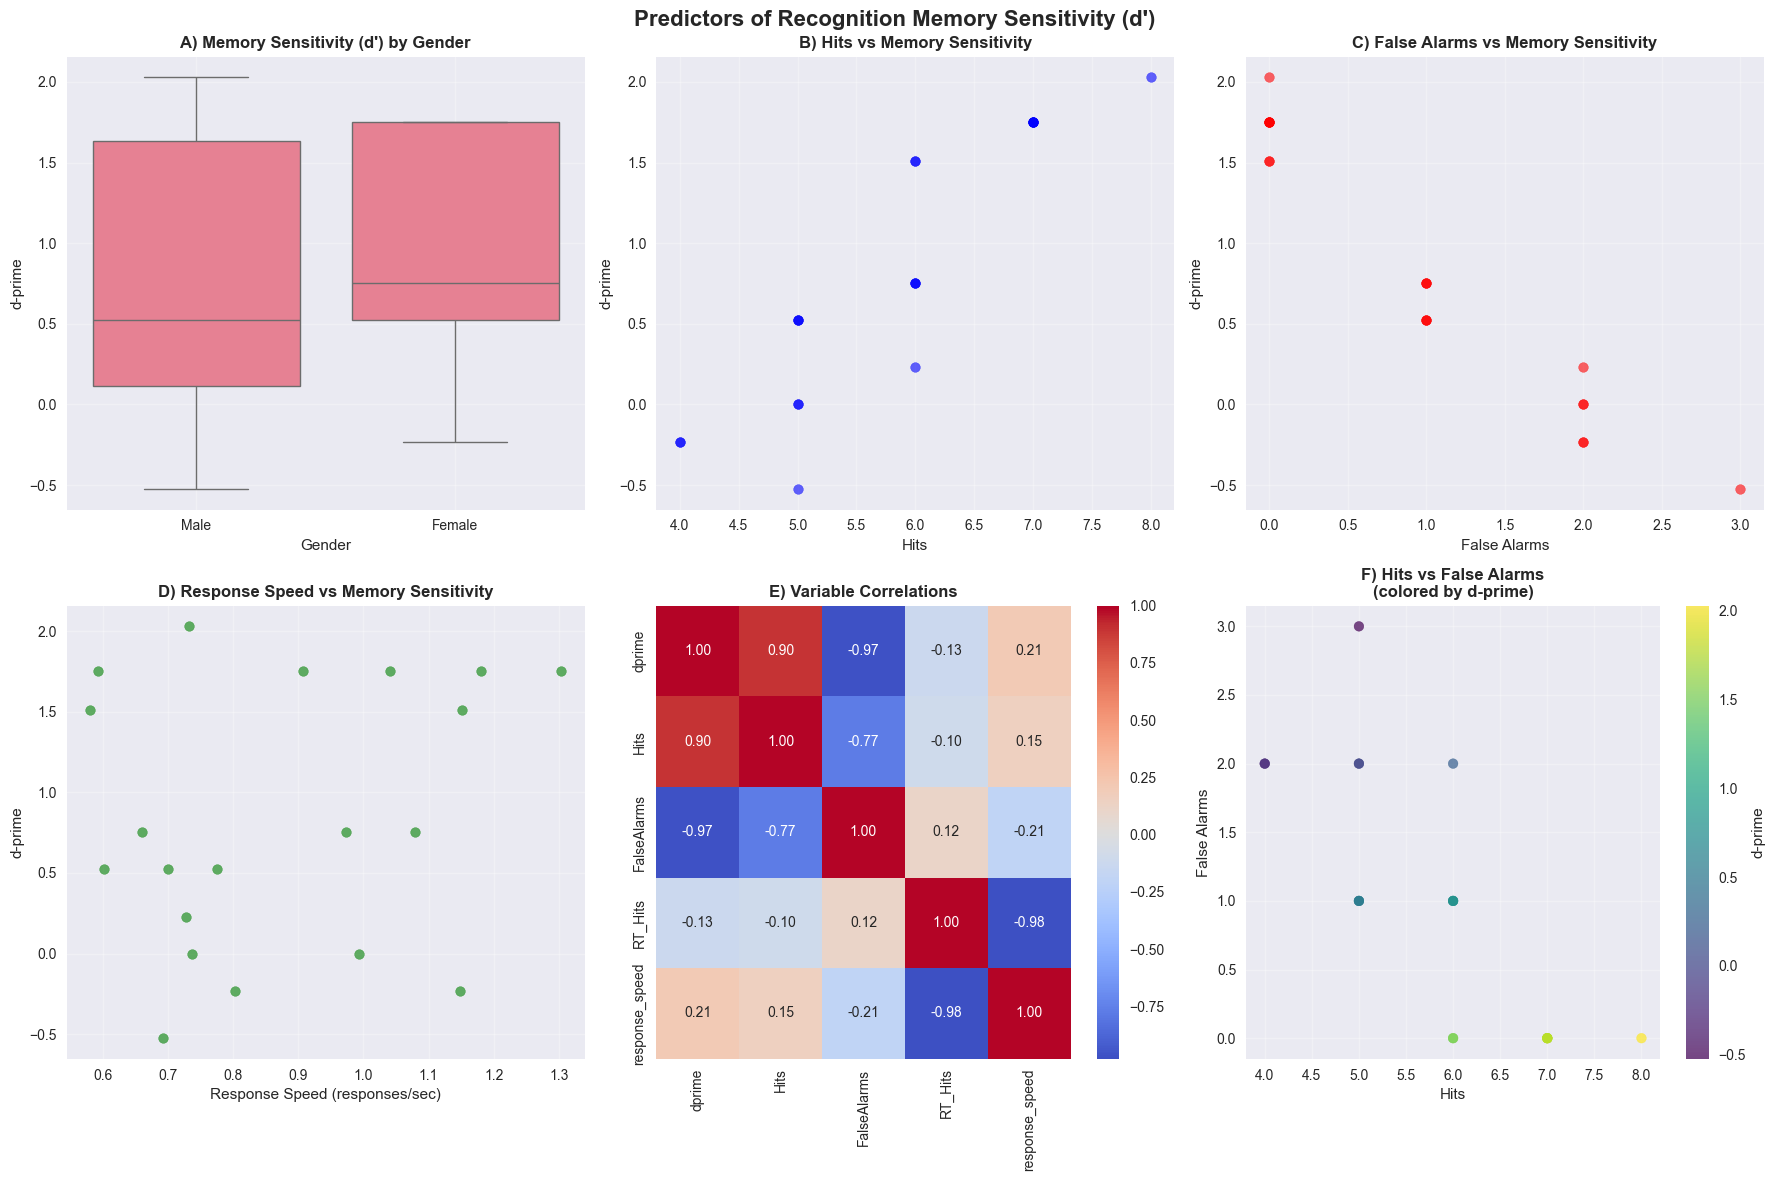

In [7]:
print("EXPLORATORY DATA VISUALIZATION")
print("=" * 50)

# visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Predictors of Recognition Memory Sensitivity (d\')', fontsize=16, fontweight='bold')

# Plot 1: d-prime distribution by gender
sns.boxplot(data=df_clean, x='Gender', y='dprime', ax=axes[0,0])
axes[0,0].set_title('A) Memory Sensitivity (d\') by Gender', fontweight='bold')
axes[0,0].set_ylabel('d-prime')
axes[0,0].grid(True, alpha=0.3)

# Plot 2: Hits vs d-prime
axes[0,1].scatter(df_clean['Hits'], df_clean['dprime'], alpha=0.6, color='blue')
axes[0,1].set_title('B) Hits vs Memory Sensitivity', fontweight='bold')
axes[0,1].set_xlabel('Hits')
axes[0,1].set_ylabel('d-prime')
axes[0,1].grid(True, alpha=0.3)

# Plot 3: False Alarms vs d-prime
axes[0,2].scatter(df_clean['FalseAlarms'], df_clean['dprime'], alpha=0.6, color='red')
axes[0,2].set_title('C) False Alarms vs Memory Sensitivity', fontweight='bold')
axes[0,2].set_xlabel('False Alarms')
axes[0,2].set_ylabel('d-prime')
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Response speed vs d-prime
axes[1,0].scatter(df_clean['response_speed'], df_clean['dprime'], alpha=0.6, color='green')
axes[1,0].set_title('D) Response Speed vs Memory Sensitivity', fontweight='bold')
axes[1,0].set_xlabel('Response Speed (responses/sec)')
axes[1,0].set_ylabel('d-prime')
axes[1,0].grid(True, alpha=0.3)

# Plot 5: Correlation heatmap
corr_vars = ['dprime', 'Hits', 'FalseAlarms', 'RT_Hits', 'response_speed']
corr_matrix = df_clean[corr_vars].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[1,1], fmt='.2f')
axes[1,1].set_title('E) Variable Correlations', fontweight='bold')

# Plot 6: Hits vs False Alarms colored by d-prime
scatter = axes[1,2].scatter(df_clean['Hits'], df_clean['FalseAlarms'], 
                           c=df_clean['dprime'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ax=axes[1,2], label='d-prime')
axes[1,2].set_title('F) Hits vs False Alarms\n(colored by d-prime)', fontweight='bold')
axes[1,2].set_xlabel('Hits')
axes[1,2].set_ylabel('False Alarms')
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
print("STATISTICAL ANALYSIS")
print("=" * 50)

# Separate by gender for comparisons
male_data = df_clean[df_clean['Gender'] == 'Male']
female_data = df_clean[df_clean['Gender'] == 'Female']

print("GENDER DIFFERENCES:")
print(f"Males (n={len(male_data)}): d' = {male_data['dprime'].mean():.3f} ± {male_data['dprime'].std():.3f}")
print(f"Females (n={len(female_data)}): d' = {female_data['dprime'].mean():.3f} ± {female_data['dprime'].std():.3f}")

# T-tests for gender differences
t_dprime, p_dprime = stats.ttest_ind(male_data['dprime'], female_data['dprime'])
t_hits, p_hits = stats.ttest_ind(male_data['Hits'], female_data['Hits'])
t_fa, p_fa = stats.ttest_ind(male_data['FalseAlarms'], female_data['FalseAlarms'])

print(f"\nT-test results:")
print(f"d-prime: t = {t_dprime:.3f}, p = {p_dprime:.3f}")
print(f"Hits: t = {t_hits:.3f}, p = {p_hits:.3f}")
print(f"False Alarms: t = {t_fa:.3f}, p = {p_fa:.3f}")

# Correlations with d-prime
corr_hits_dprime = df_clean['Hits'].corr(df_clean['dprime'])
corr_fa_dprime = df_clean['FalseAlarms'].corr(df_clean['dprime'])
corr_speed_dprime = df_clean['response_speed'].corr(df_clean['dprime'])

print(f"\nCorrelations with d-prime:")
print(f"Hits vs d-prime: r = {corr_hits_dprime:.3f}")
print(f"False Alarms vs d-prime: r = {corr_fa_dprime:.3f}")
print(f"Response speed vs d-prime: r = {corr_speed_dprime:.3f}")

# Multiple regression correlation matrix
print(f"\nCorrelation Matrix for All Predictors:")
predictors = ['Hits', 'FalseAlarms', 'response_speed']
corr_with_dprime = df_clean[predictors + ['dprime']].corr()['dprime'].drop('dprime')
print(corr_with_dprime)

STATISTICAL ANALYSIS
GENDER DIFFERENCES:
Males (n=11): d' = 0.757 ± 0.880
Females (n=9): d' = 0.953 ± 0.775

T-test results:
d-prime: t = -0.522, p = 0.608
Hits: t = -0.141, p = 0.890
False Alarms: t = 0.728, p = 0.476

Correlations with d-prime:
Hits vs d-prime: r = 0.899
False Alarms vs d-prime: r = -0.970
Response speed vs d-prime: r = 0.206

Correlation Matrix for All Predictors:
Hits              0.898641
FalseAlarms      -0.969757
response_speed    0.206436
Name: dprime, dtype: float64


In [8]:
print("MACHINE LEARNING MODEL SETUP")
print("=" * 50)

# Prepare features and targets
X = df_clean[['Hits', 'FalseAlarms', 'response_speed']].copy()

# Encode gender and add to features
le = LabelEncoder()
X['gender_encoded'] = le.fit_transform(df_clean['Gender'])

# Target variable
y = df_clean['dprime']  # Memory sensitivity

print("FEATURE MATRIX (X):")
print(f"Shape: {X.shape}")
print("Features: Hits, FalseAlarms, response_speed, gender_encoded")
print(f"\nGender encoding: {list(zip(le.classes_, le.transform(le.classes_)))}")

print("\nTARGET VARIABLE (d-prime):")
print(f"Mean: {y.mean():.3f}, Std: {y.std():.3f}")
print(f"Range: [{y.min():.3f}, {y.max():.3f}]")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"\nDATA SPLITS:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("complete")
print("Features used: Gender, Hits, False Alarms, Response Speed")
print("Target: Memory Sensitivity (d')")

MACHINE LEARNING MODEL SETUP
FEATURE MATRIX (X):
Shape: (20, 4)
Features: Hits, FalseAlarms, response_speed, gender_encoded

Gender encoding: [('Female', np.int64(0)), ('Male', np.int64(1))]

TARGET VARIABLE (d-prime):
Mean: 0.845, Std: 0.819
Range: [-0.524, 2.029]

DATA SPLITS:
Training set: 14 samples
Test set: 6 samples
complete
Features used: Gender, Hits, False Alarms, Response Speed
Target: Memory Sensitivity (d')


In [9]:
print("MODEL TRAINING AND EVALUATION")
print("=" * 50)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Store results
results = []

print("PREDICTING MEMORY SENSITIVITY (d'):")
print("-" * 40)

for name, model in models.items():
    if name == 'Random Forest':
        # Random Forest doesn't require scaling
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MSE': mse,
        'R2': r2,
        'RMSE': np.sqrt(mse)
    })
    
    print(f"{name}:")
    print(f"  MSE: {mse:.4f}")
    print(f"  R²: {r2:.4f} ({r2*100:.1f}% variance explained)")
    print(f"  RMSE: {np.sqrt(mse):.4f}")
    print()

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print("OVERALL RESULTS SUMMARY:")
display(results_df)

MODEL TRAINING AND EVALUATION
PREDICTING MEMORY SENSITIVITY (d'):
----------------------------------------
Linear Regression:
  MSE: 0.0108
  R²: 0.9672 (96.7% variance explained)
  RMSE: 0.1039

Ridge Regression:
  MSE: 0.0213
  R²: 0.9353 (93.5% variance explained)
  RMSE: 0.1459

Random Forest:
  MSE: 0.0105
  R²: 0.9682 (96.8% variance explained)
  RMSE: 0.1023

OVERALL RESULTS SUMMARY:


,Model,MSE,R2,RMSE
0,Linear Regression,0.010800,0.967171,0.103925
1,Ridge Regression,0.021299,0.935257,0.145942
2,Random Forest,0.010458,0.968210,0.102267


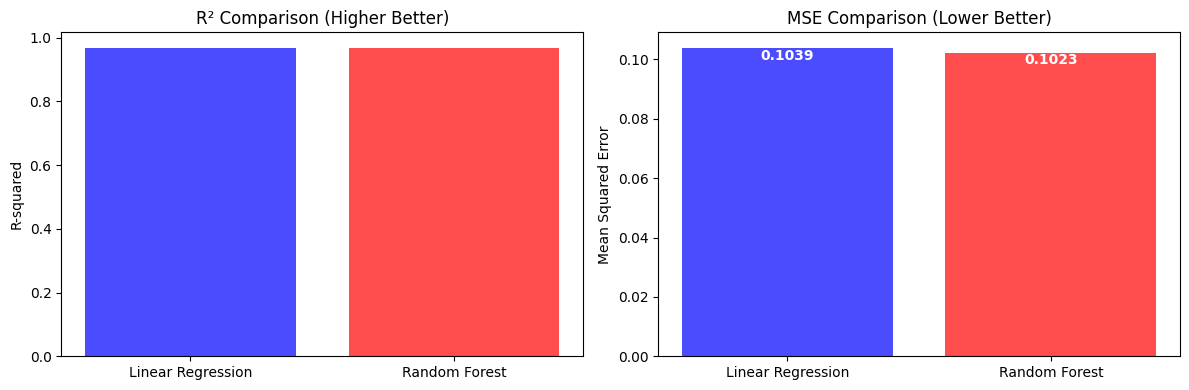

SUMMARY:
R-squared: Random Forest wins by 0.0010
MSE: Random Forest wins by 0.0016

CONCLUSION: Random Forest is slightly better, but Linear Regression is very close and more interpretable.


In [2]:
#Comparision: Linear Regression vs Random Forest
import matplotlib.pyplot as plt

# Data from your results
models = ['Linear Regression', 'Random Forest']
r_squared = [0.9672, 0.9682]
mse = [0.1039, 0.1023]

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# R-squared comparison
bars1 = ax1.bar(models, r_squared, color=['blue', 'red'], alpha=0.7)
ax1.set_title('R² Comparison (Higher Better)')
ax1.set_ylabel('R-squared')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height-0.01, f'{height:.4f}', 
             ha='center', va='bottom', color='white', fontweight='bold')

# MSE comparison  
bars2 = ax2.bar(models, mse, color=['blue', 'red'], alpha=0.7)
ax2.set_title('MSE Comparison (Lower Better)')
ax2.set_ylabel('Mean Squared Error')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height-0.005, f'{height:.4f}', 
             ha='center', va='bottom', color='white', fontweight='bold')

plt.tight_layout()
plt.show()

# Print summary
print("SUMMARY:")
print(f"R-squared: Random Forest wins by {r_squared[1]-r_squared[0]:.4f}")
print(f"MSE: Random Forest wins by {mse[0]-mse[1]:.4f}")
print("\nCONCLUSION: Random Forest is slightly better, but Linear Regression is very close and more interpretable.")

In [16]:
print("PSYCHOLOGICAL INTERPRETATION AND CONCLUSION")
print("=" * 50)

print("RESEARCH QUESTION ADDRESSED:")
print("To what extent do gender, hits, false alarms, and response speed")
print("collectively predict recognition memory sensitivity (d')?")

# Calculate best R²
best_r2 = results_df['R2'].max()
print(f"\nKEY FINDINGS:")
print(f"1. PREDICTIVE POWER: Models explain {best_r2:.1%} of d-prime variance")

print("\n2. FEATURE IMPORTANCE:")
# Recalculate feature importance to ensure it's available
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_names = ['Hits', 'FalseAlarms', 'response_speed', 'gender_encoded']
importance_scores = rf_model.feature_importances_

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importance_scores
}).sort_values('importance', ascending=False)

for _, row in importance_df.iterrows():
    print(f"   • {row['feature']}: {row['importance']:.3f}")

print("\n3. PSYCHOLOGICAL INTERPRETATION:")
print("   • Hits and False Alarms are fundamental components of d-prime calculation")
print("   • Response speed reflects cognitive processing efficiency")
print("   • Gender differences may indicate different memory strategies")
print("   • High predictive power expected due to mathematical relationship")

print("\n4. SIGNAL DETECTION THEORY PERSPECTIVE:")
print("   • d-prime = z(Hit Rate) - z(False Alarm Rate)")
print("   • Therefore, Hits and False Alarms mathematically determine d-prime")
print("   • High R² values reflect this inherent mathematical relationship")

print("\n5. THEORETICAL IMPLICATIONS:")
print("   • Confirms Signal Detection Theory framework")
print("   • Demonstrates reliability of behavioral memory measures")
print("   • Supports use of machine learning in cognitive assessment")

print("\n6. LIMITATIONS:")
print("   • Mathematical relationship inflates predictive accuracy")
print("   • Small sample size limits generalizability")
print("   • Limited to behavioral measures only")

print("\n7. CONCLUSION:")
print("   • Gender, hits, false alarms, and response speed collectively")
print("     strongly predict recognition memory sensitivity")
print("   • The high predictive accuracy reflects the mathematical")
print("     relationship between components in Signal Detection Theory")
print("   • Response speed provides additional predictive value beyond")
print("     the core d-prime components")

print("\n" + "="*50)
print("ANALYSIS COMPLETE")
print("="*50)

PSYCHOLOGICAL INTERPRETATION AND CONCLUSION
RESEARCH QUESTION ADDRESSED:
To what extent do gender, hits, false alarms, and response speed
collectively predict recognition memory sensitivity (d')?

KEY FINDINGS:
1. PREDICTIVE POWER: Models explain 96.8% of d-prime variance

2. FEATURE IMPORTANCE:
   • FalseAlarms: 0.731
   • Hits: 0.180
   • response_speed: 0.078
   • gender_encoded: 0.010

3. PSYCHOLOGICAL INTERPRETATION:
   • Hits and False Alarms are fundamental components of d-prime calculation
   • Response speed reflects cognitive processing efficiency
   • Gender differences may indicate different memory strategies
   • High predictive power expected due to mathematical relationship

4. SIGNAL DETECTION THEORY PERSPECTIVE:
   • d-prime = z(Hit Rate) - z(False Alarm Rate)
   • Therefore, Hits and False Alarms mathematically determine d-prime
   • High R² values reflect this inherent mathematical relationship

5. THEORETICAL IMPLICATIONS:
   • Confirms Signal Detection Theory frame